<a href="https://colab.research.google.com/github/alrz199/Cycle-GAN/blob/main/Cycle_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## implementing a Cycle GAN model to transform apple emojis to those of windows and vice versa.

In [ ]:
!pip install --quiet torchmetrics pytorch_lightning opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 18.9 MB/s eta 0:00:00


In [ ]:
# import libraries
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader,random_split
import numpy as np
import math

from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
import torch.nn as nn

In [ ]:
# this cell will get and prepare the pictures for us
# it is assumed that all imges have the same size(32*32)
from torchvision import transforms
import os
transform_t = transforms.Compose([transforms.Normalize([0,0,0],[255,255,255])])
class dataset(Dataset):
    """Face Landmarks dataset."""
    def __init__(self, path1,path2, transform=transform_t):

        self.applimages,self.windimages = self.get_dataset(path1,path2)
    def __len__(self):
        return len(self.applimages)

    def __getitem__(self, idx):
        sample=self.applimages[idx],self.windimages[idx]
        return sample
    def get_dataset(self,path1,path2):
      #get apple emojis and normalize them
        filenames = [name for name in os.listdir(path1)]
        images=[]
        for i, filename in enumerate(filenames[0:]):
            pth=os.path.join(path1, filename)
            img = torchvision.io.read_image(pth).type(torch.float)
            if img.shape[0]==1:
               img=torch.cat((img,img,img))
            if img.shape[0]==3:
               img_normalized = transform_t(img)
               images.append(img_normalized)
        appl_images = torch.stack(images).type(torch.float)
      #get windows emojis and normalize them
        filenames = [name for name in os.listdir(path2)]
        images=[]
        for i, filename in enumerate(filenames[0:]):
            pth=os.path.join(path2, filename)
            img = torchvision.io.read_image(pth).type(torch.float)
            if img.shape[0]==1:
               img=torch.cat((img,img,img))
            if img.shape[0]==3:
               img_normalized = transform_t(img)
               images.append(img_normalized)
        wind_images = torch.stack(images).type(torch.float)
        return appl_images[0:wind_images.shape[0]],wind_images

In [ ]:
# read_data
# these datasets contain 32*32 images of apple and windows emojis
from torch.utils.data import Dataset, DataLoader,random_split
train_data = dataset('/content/drive/MyDrive/Appl__resized','/content/drive/MyDrive/Wind__resized')
test_data = dataset('/content/drive/MyDrive/Test_Appl_resized','/content/drive/MyDrive/Test_Wind_resized')

In [ ]:
train_loader = DataLoader(dataset=train_data,
                                           batch_size=128,
                                           shuffle=True)
test_loader = DataLoader(dataset=test_data,
                                           batch_size=8,
                                           shuffle=False)


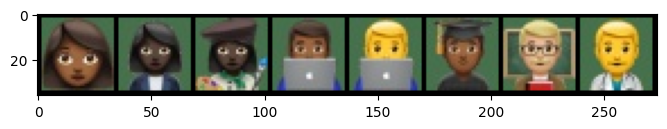

In [ ]:
from matplotlib import pyplot as plt
#let's look at one batch of the data
def imshow(img):
    img = img
    npimg = img.numpy()
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
appl,wind = next(iter(test_loader))

# show images
imshow(torchvision.utils.make_grid(appl))

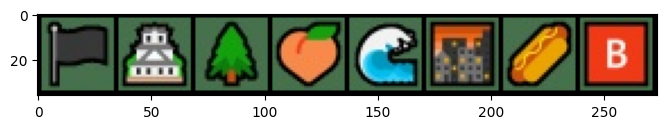

In [ ]:
imshow(torchvision.utils.make_grid(torchvision.transforms.Resize((32,32))(wind)))

In [ ]:
# the upsample unit will increase the size of the image...we will use this block to move from the latent space to
# a complete image
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=True):
        super(Upsample, self).__init__()
        self.dropout = dropout
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.dropout_layer = nn.Dropout2d(0.5)

    def forward(self, x, shortcut=None):
        x = self.block(x)
        if self.dropout:
            x = self.dropout_layer(x)
# when we combine upsample and downsample unit, we want connections from the encoded layers to the
# reconstruction layers
        if shortcut is not None:
            x = torch.cat([x, shortcut], dim=1)

        return x

In [ ]:
# example use of upsample unit
us = Upsample(3,8)
us(wind).shape

torch.Size([8, 8, 64, 64])

In [ ]:
# the dowsample unit's job is to get an image and provide a vector in the latent space that has
# the important information of the image
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_instancenorm=True):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.apply_norm = apply_instancenorm

    def forward(self, x):
        x = self.conv(x)
        if self.apply_norm:
            x = self.norm(x)
        x = self.relu(x)

        return x

In [ ]:
# example use of downsample unit
ds = Downsample(3,8)
ds(wind).shape

torch.Size([8, 8, 16, 16])

In [ ]:
#the generator of the cycle gan
# it uses downsample units and upsample units stacked together
class CycleGAN_Unet_Generator(nn.Module):
    def __init__(self, filter=1):
        super(CycleGAN_Unet_Generator, self).__init__()
        self.downsamples = nn.ModuleList([
            Downsample(3, filter * 8),
            Downsample(filter * 8, filter * 8),
            Downsample(filter * 8, filter * 8),
            Downsample(filter * 8, filter * 8)
        ])

        self.upsamples = nn.ModuleList([
            Upsample(filter * 8, filter * 8),
            Upsample(filter * 16, filter * 8),
            Upsample(filter * 16, filter * 8)
        ])

        self.last = nn.Sequential(
            nn.ConvTranspose2d(filter * 16, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        skips = []
        for l in self.downsamples:
            x = l(x)
            skips.append(x)
# providing middle connections in the network..we want last layers of the encoder to be
# connected to the first layers of the decoder
        skips = reversed(skips[:-1])
        for l, s in zip(self.upsamples, skips):
            x = l(x, s)

        out = self.last(x)

        return out



In [ ]:
gen = CycleGAN_Unet_Generator()
gen(wind).shape

torch.Size([8, 3, 32, 32])

In [ ]:
# our discriminator
# its job should be downsampling an image and checking if it is real or fake
class CycleGAN_Discriminator(nn.Module):
    def __init__(self, filter=1):
        super(CycleGAN_Discriminator, self).__init__()
        self.block = nn.Sequential(
            Downsample(3, filter*8, kernel_size=4, stride=1, apply_instancenorm=False),
            Downsample(filter*8, filter * 8, kernel_size=4, stride=1),
            Downsample(filter * 8, filter * 8, kernel_size=4, stride=1),
            Downsample(filter * 8, filter * 8, kernel_size=4, stride=1),
        )

        self.last = nn.Conv2d(filter * 8, 1, kernel_size=3, stride=1, padding=3)

    def forward(self, x):
        x = self.block(x)
        x = self.last(x)
        return x

In [ ]:
dis = CycleGAN_Discriminator()
dis(wind).shape

torch.Size([8, 1, 32, 32])

In [ ]:
# CycleGAN - Lightning Module ---------------------------------------------------------------------------
class CycleGAN_LightningSystem(LightningModule):
    def __init__(self, G_basestyle, G_stylebase, D_base, D_style, lr, reconstr_w=10, id_w=2,samples=test_data.applimages[0:4]):
        super(CycleGAN_LightningSystem, self).__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        self.samples=samples #we will use them to track the performance of the model
        # define our generators
        self.G_basestyle = G_basestyle
        self.G_stylebase = G_stylebase
        # define our discriminators
        self.D_base = D_base
        self.D_style = D_style
        self.lr = 0.0002
        self.reconstr_w = reconstr_w
        self.id_w = id_w
        self.cnt_train_step = 0
        self.step = 0

        self.mae = nn.L1Loss()
        self.generator_loss = nn.MSELoss()
        self.discriminator_loss = nn.MSELoss()
        self.losses = []
        self.G_mean_losses = []
        self.D_mean_losses = []
        self.validity = []
        self.reconstr = []
        self.identity = []

    def configure_optimizers(self):
# we will train both generators with one optimizer and both discriminators with another one
        parameters1 = list(self.G_basestyle.parameters()) + list(self.G_stylebase.parameters())
        g_optimizer = torch.optim.Adam(parameters1, lr=self.lr)
        parameters2 = list(self.D_base.parameters()) + list(self.D_style.parameters())
        d_optimizer = torch.optim.Adam(parameters2, lr=self.lr)
        return [g_optimizer, d_optimizer], []

    def training_step(self, batch, batch_idx):
        base_img, style_img = batch
        g_optimizer, d_optimizer = self.optimizers()
        self.toggle_optimizer(g_optimizer)
        b = base_img.shape[0]
        valid = torch.ones(b, 1, 32, 32)
        fake = torch.zeros(b, 1, 32, 32)

        # Train Generators:
            # Validity
            # MSELoss
        val_base = self.generator_loss(self.D_base(self.G_stylebase(style_img)), valid)
        val_style = self.generator_loss(self.D_style(self.G_basestyle(base_img)), valid)
        val_loss = (val_base + val_style) / 2

        # Reconstruction
        reconstr_base = self.mae(self.G_stylebase(self.G_basestyle(base_img)), base_img)
        reconstr_style = self.mae(self.G_basestyle(self.G_stylebase(style_img)), style_img)
        reconstr_loss = (reconstr_base + reconstr_style) / 2

        # Identity
        id_base = self.mae(self.G_stylebase(base_img), base_img)
        id_style = self.mae(self.G_basestyle(style_img), style_img)
        id_loss = (id_base + id_style) / 2

        # Loss Weight
        G_loss = val_loss + self.reconstr_w * reconstr_loss + self.id_w * id_loss

        self.log("g_loss", G_loss, prog_bar=True)
        self.manual_backward(G_loss)
        g_optimizer.step()
        g_optimizer.zero_grad()
        self.untoggle_optimizer(g_optimizer)



        self.toggle_optimizer(d_optimizer)
        # Train Discriminators:
            # MSELoss
        D_base_gen_loss = self.discriminator_loss(self.D_base(self.G_stylebase(style_img).detach()), fake)
        D_style_gen_loss = self.discriminator_loss(self.D_style(self.G_basestyle(base_img).detach()), fake)
        D_base_valid_loss = self.discriminator_loss(self.D_base(base_img), valid)
        D_style_valid_loss = self.discriminator_loss(self.D_style(style_img), valid)


            # Loss Weight
        D_loss = ((D_base_gen_loss + D_style_gen_loss) + D_base_valid_loss + D_style_valid_loss) / 4

        self.log("d_loss", D_loss, prog_bar=True)
        self.manual_backward(D_loss)
        d_optimizer.step()
        d_optimizer.zero_grad()
        self.untoggle_optimizer(d_optimizer)

    def on_train_epoch_end(self):
            # Display Model Output
            target_imgs = self.samples.detach()
            gen_imgs = self.G_basestyle(target_imgs)
            gen_img = torch.cat([target_imgs, gen_imgs], dim=0)

            gen_img = gen_img * 255

            joined_images_tensor = torchvision.utils.make_grid(gen_img, nrow=4, padding=2)

            joined_images = joined_images_tensor.detach().cpu().numpy().astype(int)
            joined_images = np.transpose(joined_images, [1,2,0])

            # Visualize
            fig = plt.figure(figsize=(4, 4))
            plt.imshow(joined_images)
            plt.axis('off')
            plt.show()



/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'G_basestyle' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['G_basestyle'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'G_stylebase' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['G_stylebase'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'D_base' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['D_base'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'D_style' is an instance of `nn.Module` and is already saved during checkpointing. It is recommen

Training: |          | 0/? [00:00<?, ?it/s]

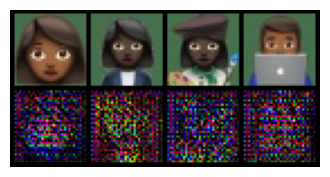

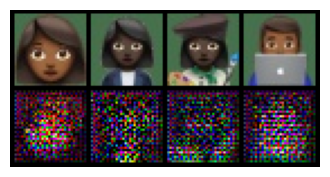

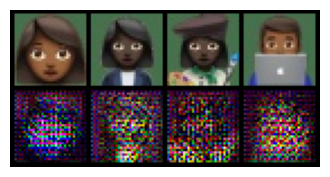

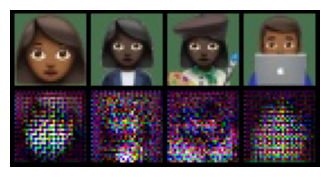

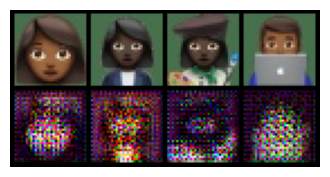

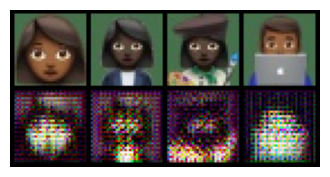

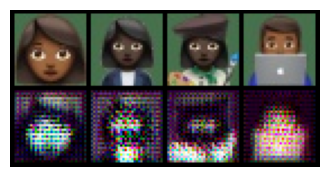

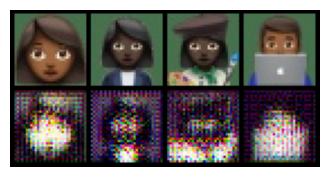

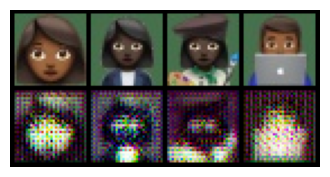

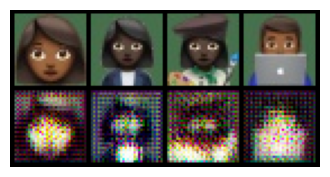

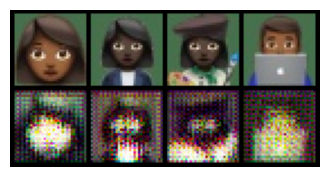

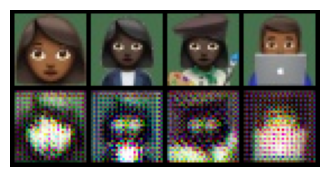

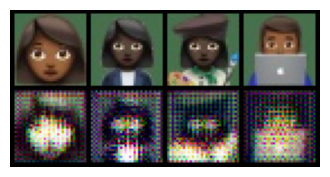

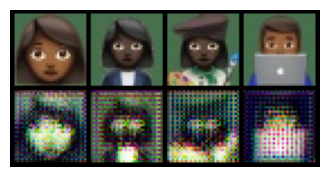

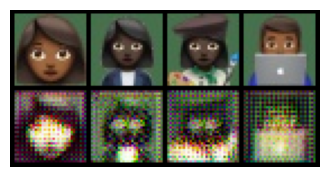

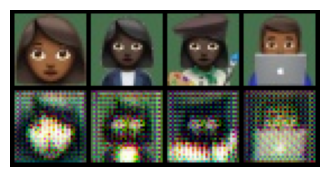

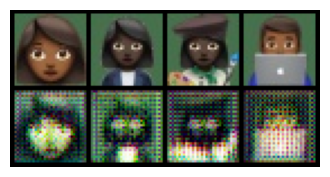

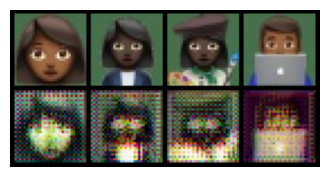

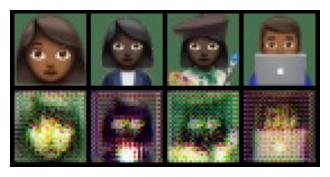

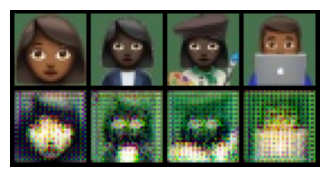

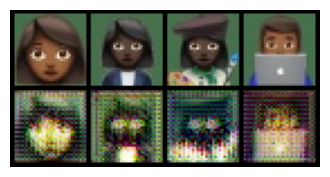

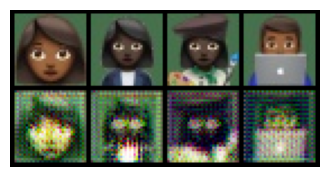

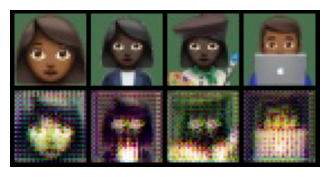

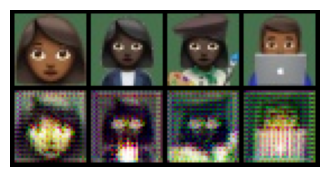

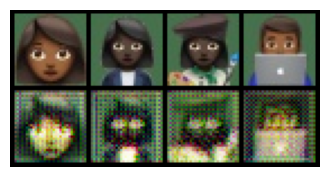

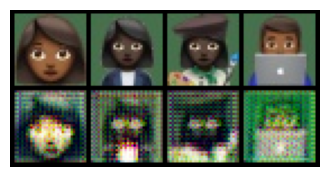

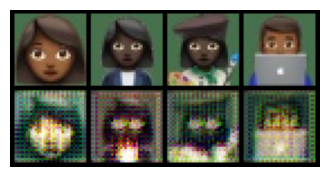

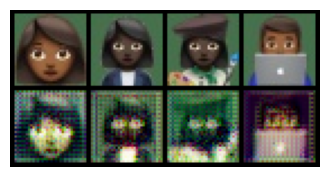

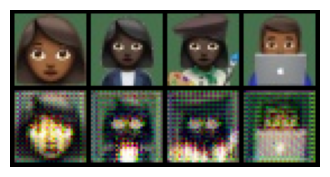

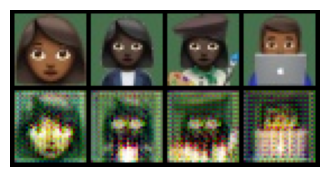

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
batch_size = 128
lr = {
    'G': 0.0002,
    'D': 0.0002
}
epoch = 10
seed = 42
reconstr_w = 10
id_w = 2


# DataModule  -----------------------------------------------------------------
train_loader = DataLoader(dataset=train_data,
                                           batch_size=128,
                                           shuffle=True)
G_basestyle = CycleGAN_Unet_Generator()
G_stylebase = CycleGAN_Unet_Generator()
D_base = CycleGAN_Discriminator()
D_style = CycleGAN_Discriminator()


# LightningModule  --------------------------------------------------------------
model = CycleGAN_LightningSystem(G_basestyle, G_stylebase, D_base, D_style,
                                 lr, reconstr_w, id_w)

# Trainer  --------------------------------------------------------------
trainer = Trainer(
    max_epochs=30,
    num_sanity_val_steps=0)


# Train
trainer.fit(model, train_loader)